# Executive Summary

### Goal
#### The aim is to develop a predictive model that will facilitate the approval of loans, with the intention of minimising issuance of bad loans and maximising interest income for the lenders.

### Metrics
#### Given the focus on minimising issuance of bad loans, a key metric is the recall value of the model. A second key metric is the precision value of the model, so as to maximise issuance of performing loans and consequently loan profits for the lenders.

### Findings
#### The model built using Logistic Regression produces a fairly high recall value, though there is a tradeoff in terms of lower precision. The top 5 predictive features used in this model are as follows: 1) Amount of remaining outstanding loan principle, 2) Date of loan issuance, 3) Date of earliest credit line, 4) Amount of collections over prior 12 months and 5) Loan amount

#### The model built using Gradient Boost produces a very high precision value, though there is a tradeoff in terms of lower recall. Given the blackbox nature of this model, the relative feature importances are not as clear.

#### The model built using Random Forest produces results that are comparable to Gradient Boost though with marginally poorer scores.

#### Given the tradeoff between precision and recall, a threshold can be set as a cutoff to account for the relative business cost of losing potential customers via incorrectly rejecting applications (false positives) and incorrectly accepting customers whom eventually default (false negative).

### Risks/Limitations/Assumptions
#### A key limitation of the data is that some level of screening has already been conducted by the loan agency (Lending Club) as we are dealing with loans that have been issued. Hence, the model does not factor in all possible attributes related to the entire population of loan applications.
#### The is a clear risk-reward tradeoff between minimising the issuance of bad loans (and limiting losses) and maximising the issuance of good loans (and increasing profits). The acceptable cutoff and threshold level is a decision for the business to make.

In [30]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option('display.max_columns', 200)
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

from sklearn.decomposition import PCA
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score, adjusted_mutual_info_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from collections import Counter
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, average_precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, binarize
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from xgboost import XGBClassifier

In [17]:
data = pd.read_pickle('dataupdate28042018.pkl')
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,DEFAULT
42536,27050.0,27050.0,27050.0,36 months,10.99,885.46,B,B2,team leadern customer ops & systems,10+ years,OWN,55000.0,Verified,Dec-2013,debt_consolidation,481xx,MI,22.87,0.0,Oct-1986,0.0,0.0,14.0,0.0,36638.0,61.2%,27.0,w,10018.90,10018.90,21251.04,21251.04,17031.10,4219.94,0.0,0.0,0.0,885.46,Feb-2016,Dec-2015,0.0,INDIVIDUAL,0.0,0.0,114834.0,59900.0,0
42537,9750.0,9750.0,9750.0,36 months,13.98,333.14,C,C1,medical assistant,1 year,RENT,26000.0,Not Verified,Dec-2013,debt_consolidation,927xx,CA,25.12,0.0,Jan-2007,0.0,0.0,12.0,0.0,7967.0,52.8%,28.0,f,3710.96,3710.96,7994.83,7994.83,6039.04,1955.79,0.0,0.0,0.0,333.14,Feb-2016,Jan-2016,0.0,INDIVIDUAL,0.0,0.0,14123.0,15100.0,0
42538,12000.0,12000.0,12000.0,36 months,6.62,368.45,A,A2,manager information delivery,10+ years,MORTGAGE,105000.0,Not Verified,Dec-2013,debt_consolidation,060xx,CT,14.05,0.0,Mar-1994,1.0,43.0,12.0,0.0,13168.0,21.6%,22.0,w,4266.62,4266.62,8842.80,8842.80,7733.38,1109.42,0.0,0.0,0.0,368.45,Feb-2016,Jan-2016,0.0,INDIVIDUAL,0.0,0.0,267646.0,61100.0,0
42539,12000.0,12000.0,12000.0,36 months,13.53,407.40,B,B5,on road manager,10+ years,RENT,40000.0,Source Verified,Dec-2013,debt_consolidation,871xx,NM,16.94,0.0,Oct-1998,0.0,53.0,7.0,2.0,5572.0,68.8%,32.0,w,0.00,0.00,13359.77,13359.77,11999.99,1359.78,0.0,0.0,0.0,119.17,isthisrelevant?,Jan-2016,0.0,INDIVIDUAL,0.0,15386.0,13605.0,8100.0,0
42540,15000.0,15000.0,15000.0,36 months,8.90,476.30,A,A5,aircraft maintenance engineer,2 years,MORTGAGE,63000.0,Not Verified,Dec-2013,debt_consolidation,334xx,FL,16.51,0.0,Mar-1998,0.0,34.0,8.0,0.0,11431.0,74.2%,29.0,w,5449.27,5449.27,11431.20,11431.20,9550.73,1880.47,0.0,0.0,0.0,476.30,Feb-2016,Jan-2016,0.0,INDIVIDUAL,0.0,1514.0,272492.0,15400.0,0


In [18]:
data.shape

(816676, 47)

# EDA

#### Some variables selected for further analysis as part of EDA include loan amount, interest rate, instalment amount, home ownership, credit rating, annual income, employment length, loan purpose and loan term

#### Overall breakdown of good and bad loans

Text(0,0.5,u'counts')

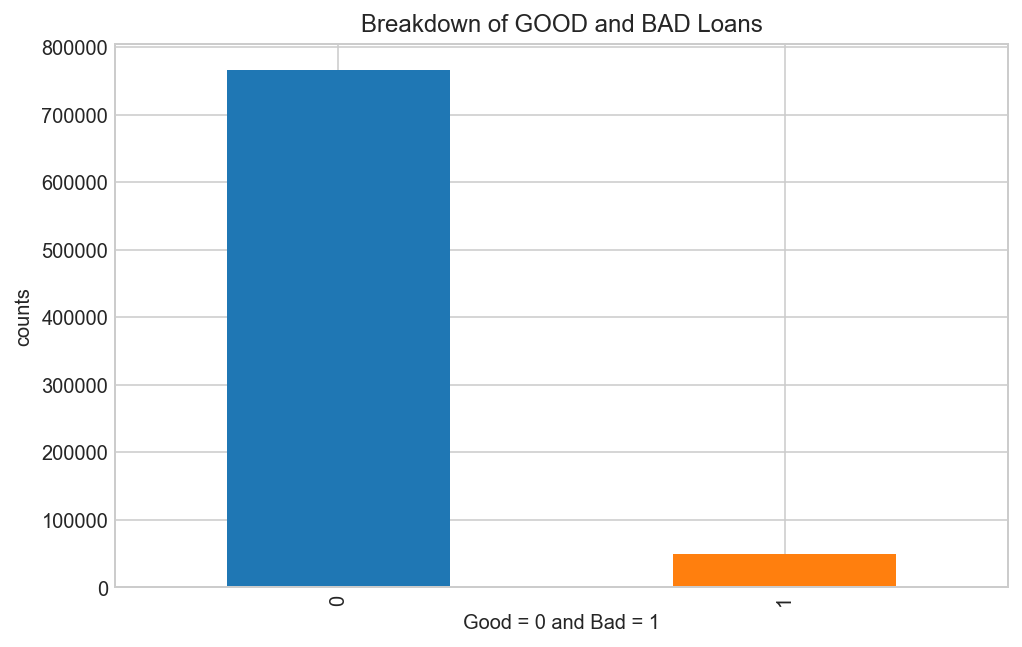

In [53]:
plt.figure(figsize=(8,5))
ax = data['DEFAULT'].value_counts().plot(kind='bar',title='Breakdown of GOOD and BAD Loans')
ax.set_xlabel("Good = 0 and Bad = 1")
ax.set_ylabel("counts")

ValueError: Colormap aqua is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

#### Distribution of loan amounts

Text(0,0.5,u'Relative Frequency')

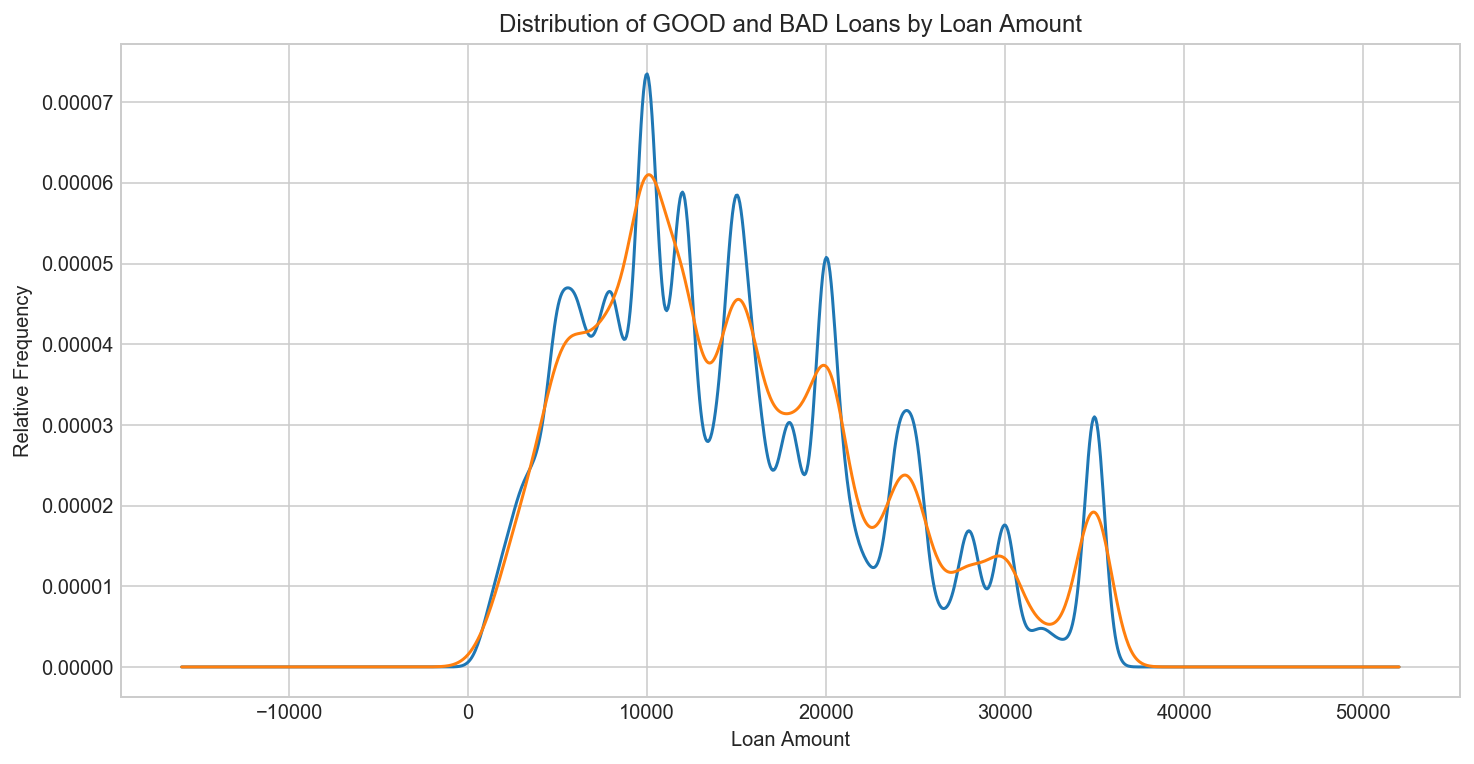

In [51]:
plt.figure(figsize=(12,6))
ax = data.groupby('DEFAULT').loan_amnt.plot(kind='kde', title='Distribution of GOOD and BAD Loans by Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Relative Frequency')

#### Distribution of Annual Income

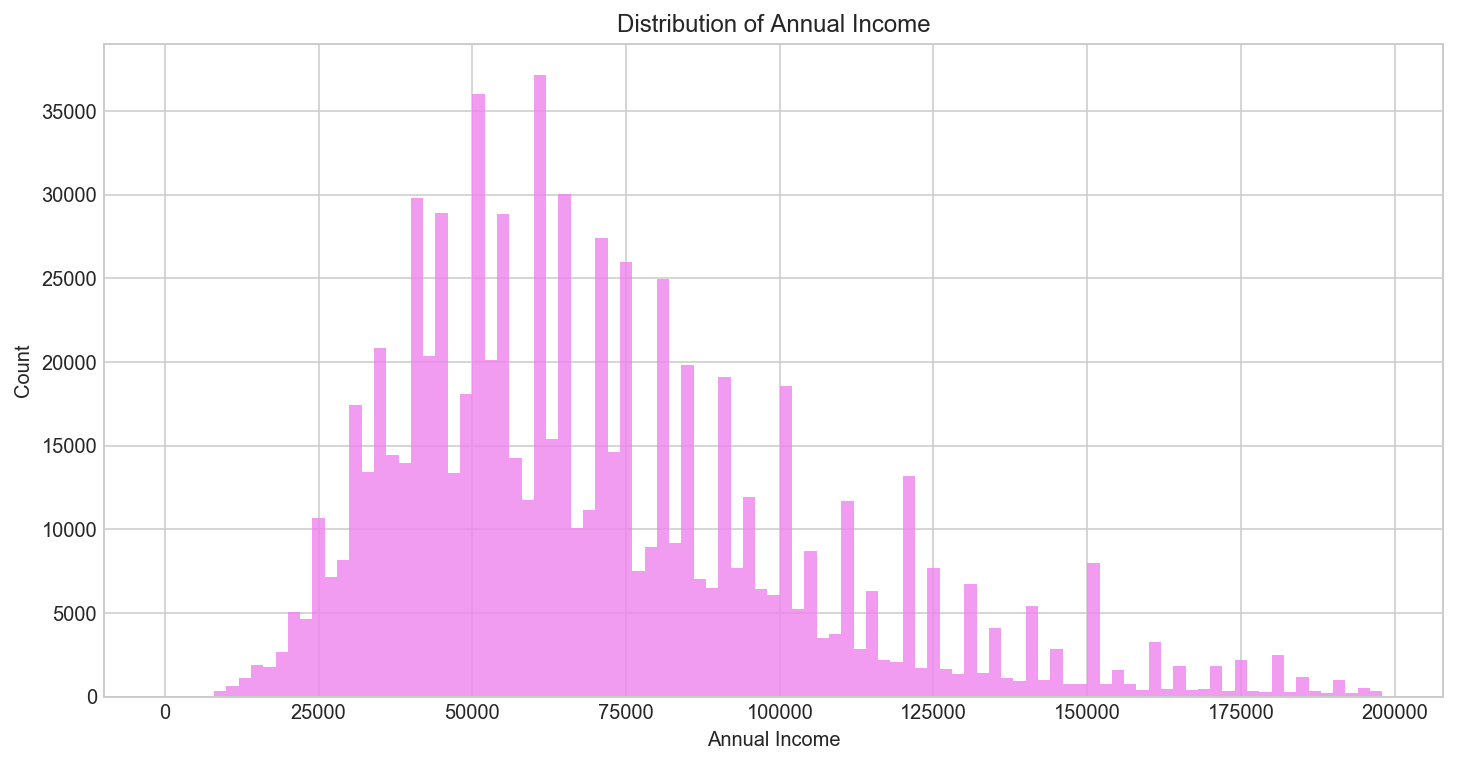

In [65]:
datatemp = data['annual_inc']
bins = np.arange(datatemp.min(), 200000, 2000)
plt.figure(figsize=(12,6))
g1 = plt.hist(datatemp, 
         bins=bins, 
         alpha=0.8, 
         color='violet')
plt.title('Distribution of Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Count')
plt.show()

#### Distribution of Interest Rates

Text(0,0.5,u'Relative Frequency')

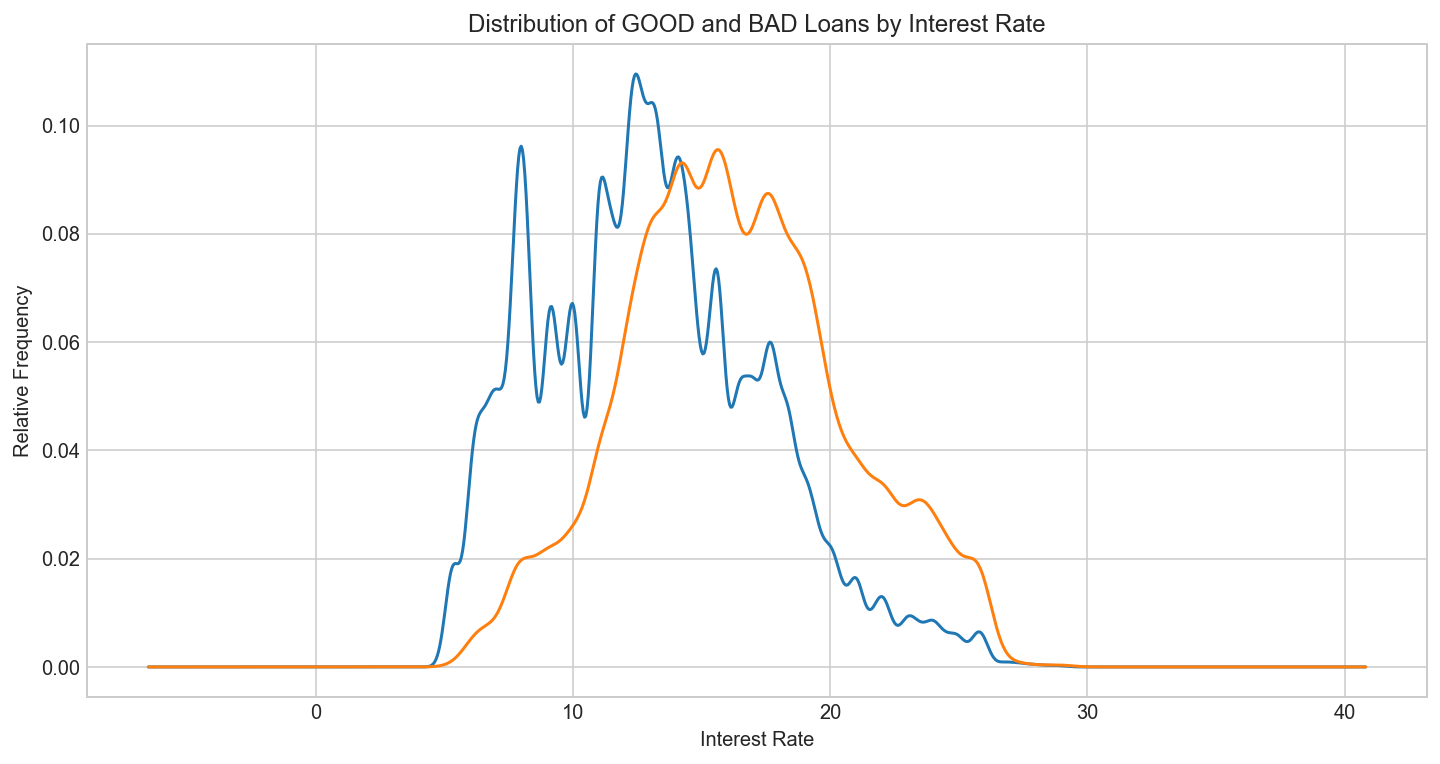

In [52]:
plt.figure(figsize=(12,6))
ax = data.groupby('DEFAULT').int_rate.plot(kind='kde', title='Distribution of GOOD and BAD Loans by Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Relative Frequency')

#### Distribution of Instalment Amounts

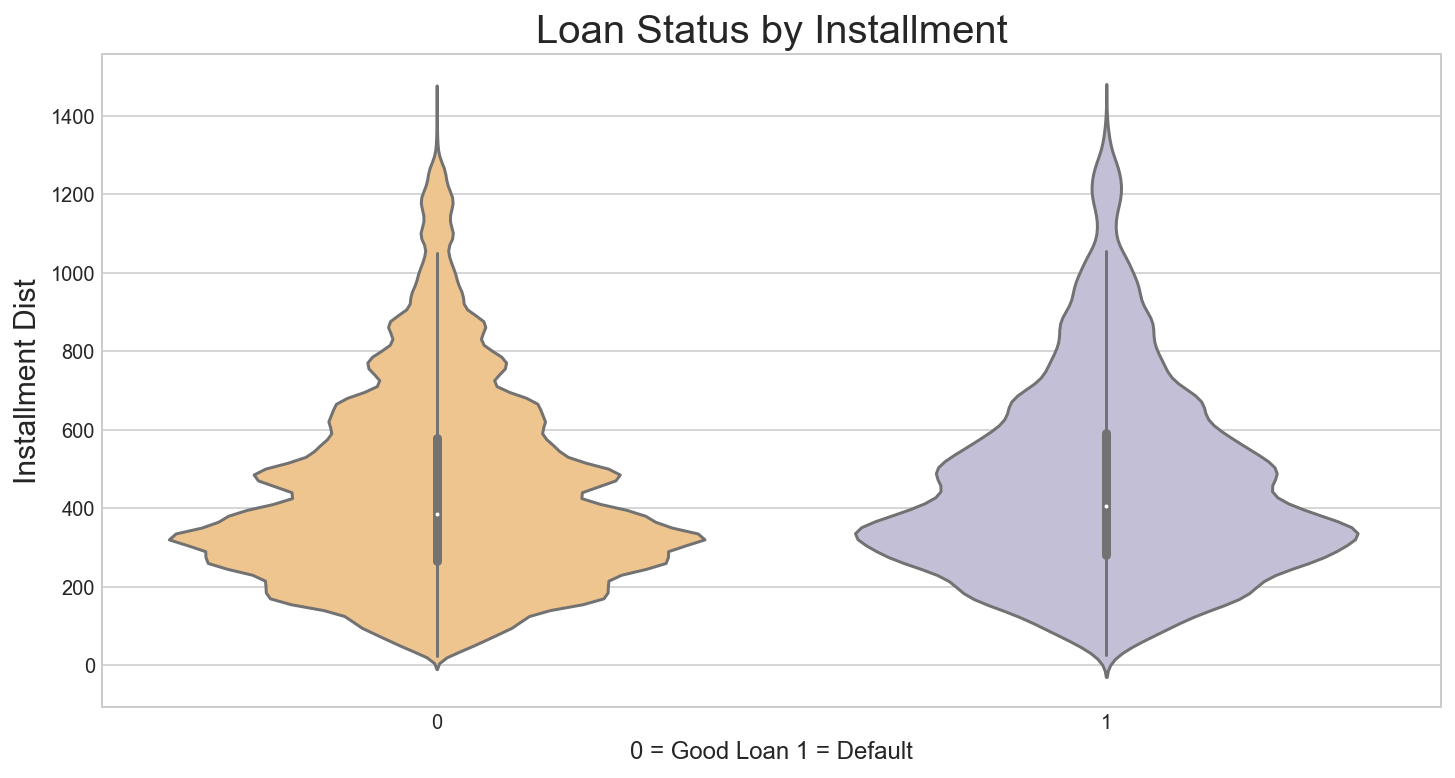

In [56]:
# loan status vs instalment
plt.figure(figsize = (12,6))

g = sns.violinplot(x='DEFAULT', y='installment',
                   data=data,palette="PuOr")
g.set_xticklabels(g.get_xticklabels())
g.set_xlabel("0 = Good Loan 1 = Default", fontsize=12)
g.set_ylabel("Installment Dist", fontsize=15)
g.set_title("Loan Status by Installment", fontsize=20)

plt.show()

#### Loan Grades

In [39]:
loan_grade = ['loan_status', 'grade']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(data[loan_grade[0]], data[loan_grade[1]]).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
DEFAULT,,,,,,,
0,129226,223259,216641,117582,58191,17705,3882
1,2191,9399,14555,12273,7452,3380,940


#### Home Ownership vs Loan Amount

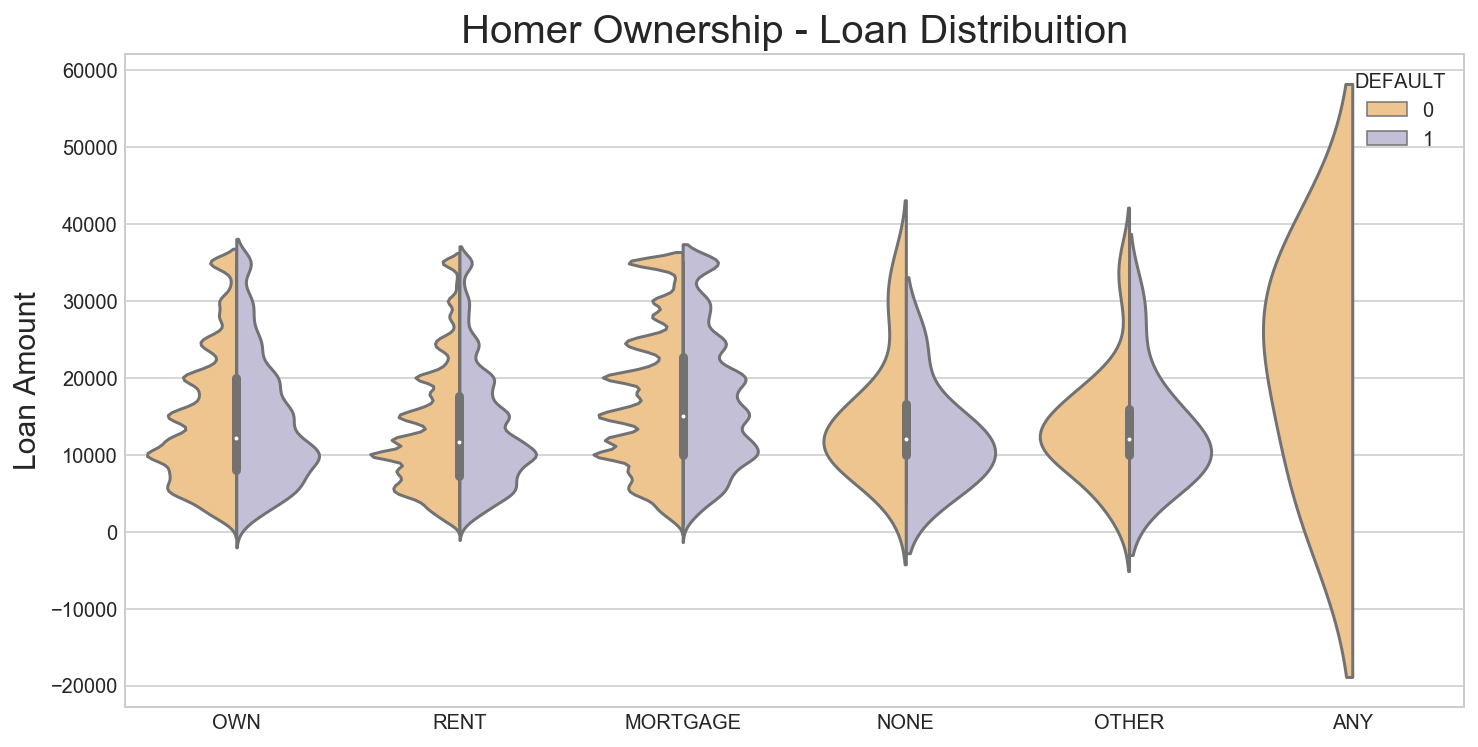

In [67]:
#home ownership, loan amount and default
plt.figure(figsize = (12,6))

g = sns.violinplot(x="home_ownership",y="loan_amnt",data=data,
               kind="violin",
               split=True,palette="PuOr",
               hue="DEFAULT")
g.set_title("Homer Ownership - Loan Distribuition", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.show()

#### Credit Rating versus 1) Loan Amount 2) Interest Rate

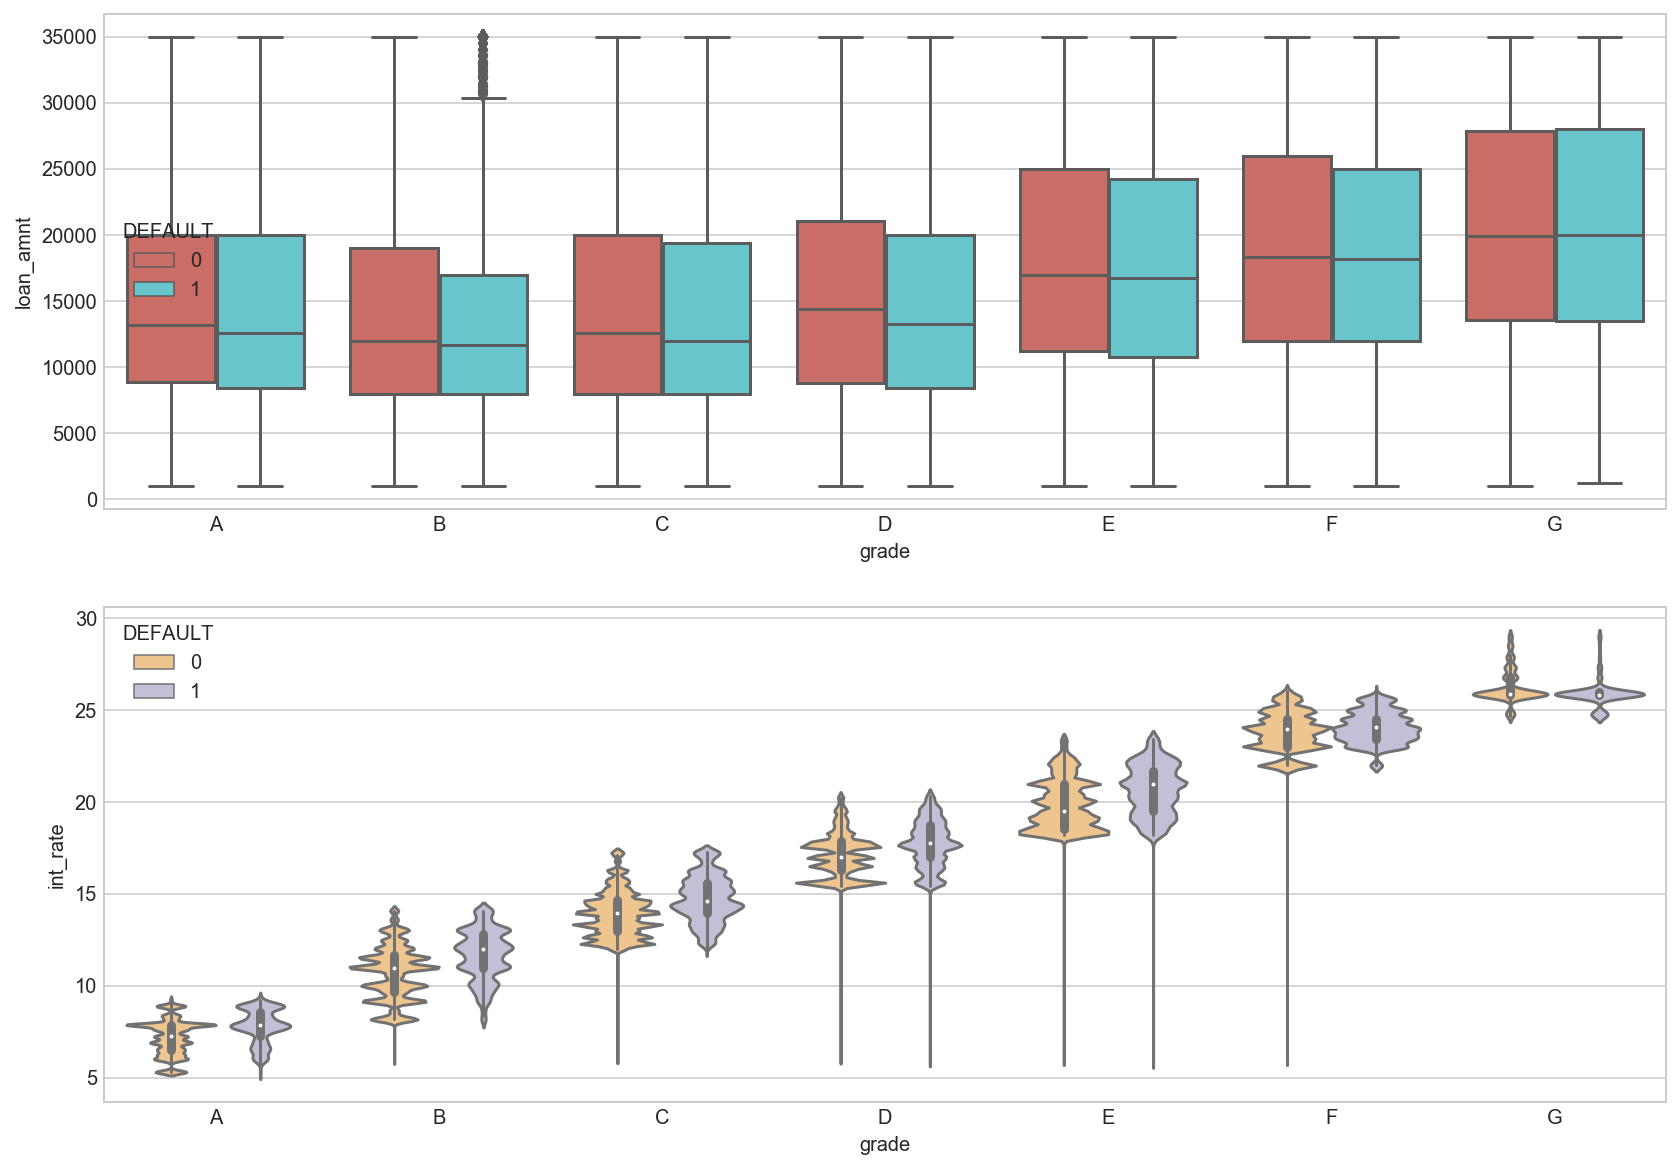

In [103]:
fig, ax = plt.subplots(2,1, figsize=(14,10))
sns.boxplot(x="grade", y="loan_amnt", data=data,
            palette="hls",ax=ax[0], hue="DEFAULT", 
            order=["A",'B','C','D','E','F', 'G'])
sns.violinplot(x='grade', y="int_rate",data=data, 
               hue="DEFAULT", palette = "PuOr", ax=ax[1], 
             order=["A",'B','C','D','E','F', 'G'])
# #sns.lvplot(x="sub_grade", y="loan_amnt",data=df_loan, 
#                palette="hls", ax=ax[2])
plt.show()

#### Breakdown of Employment Length

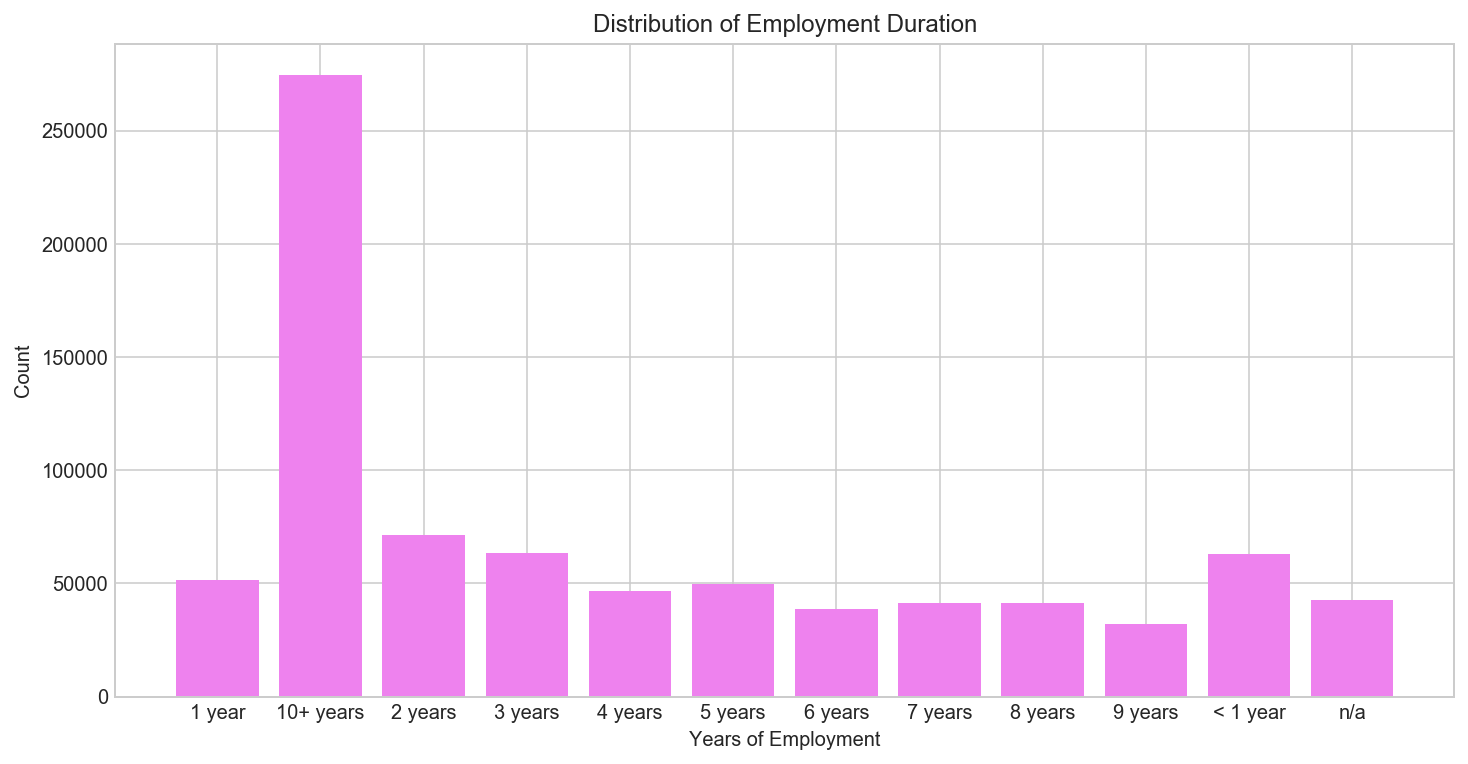

In [93]:
datatemp2 = data['emp_length'].value_counts()
datatemp3 = ['10+ years','2 years','3 years','< 1 year','1 year','5 years','4 years','n/a','7 years','8 years','6 years','9 years']
plt.figure(figsize=(12,6))
g2 = plt.bar(datatemp3, datatemp2, color='violet')
plt.title('Distribution of Employment Duration')
plt.xlabel('Years of Employment')
plt.ylabel('Count')
plt.show()

#### Breakdown of Loan Purpose

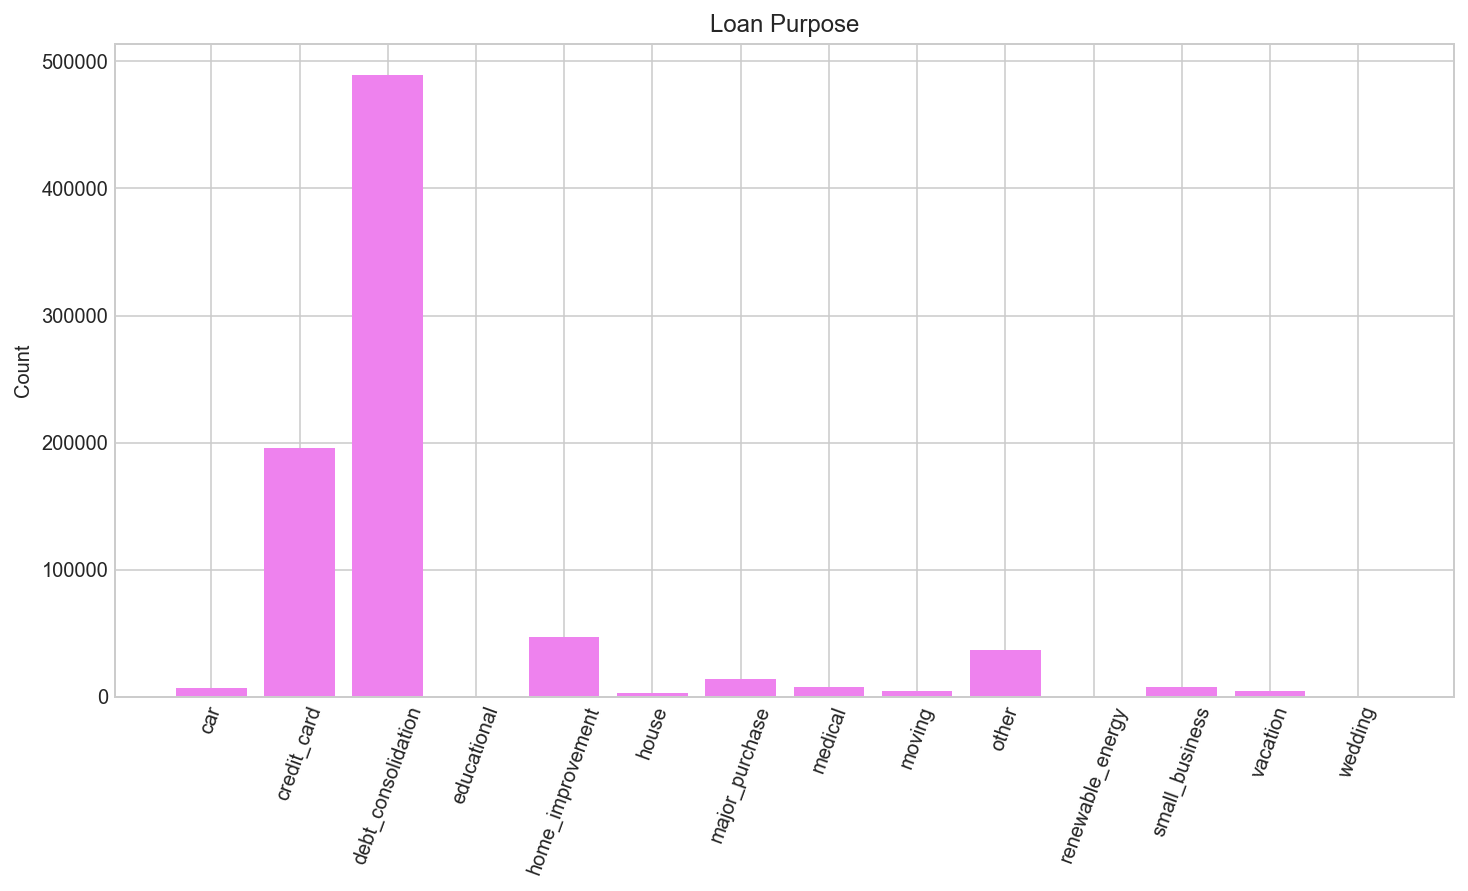

In [99]:
datatemp4 = data['purpose'].value_counts()
datatemp5 = ['debt_consolidation','credit_card','home_improvement','other','major_purchase','small_business',\
'medical','car','moving','vacation','house','wedding','renewable_energy','educational']
plt.figure(figsize=(12,6))
g2 = plt.bar(datatemp5, datatemp4, color='violet')
plt.title('Loan Purpose')
# plt.xlabel('Years of Employment')
plt.ylabel('Count')
plt.xticks(rotation=70)
plt.show()

#### Analysis of Loan Terms vs Default

Text(0,0.5,u'counts')

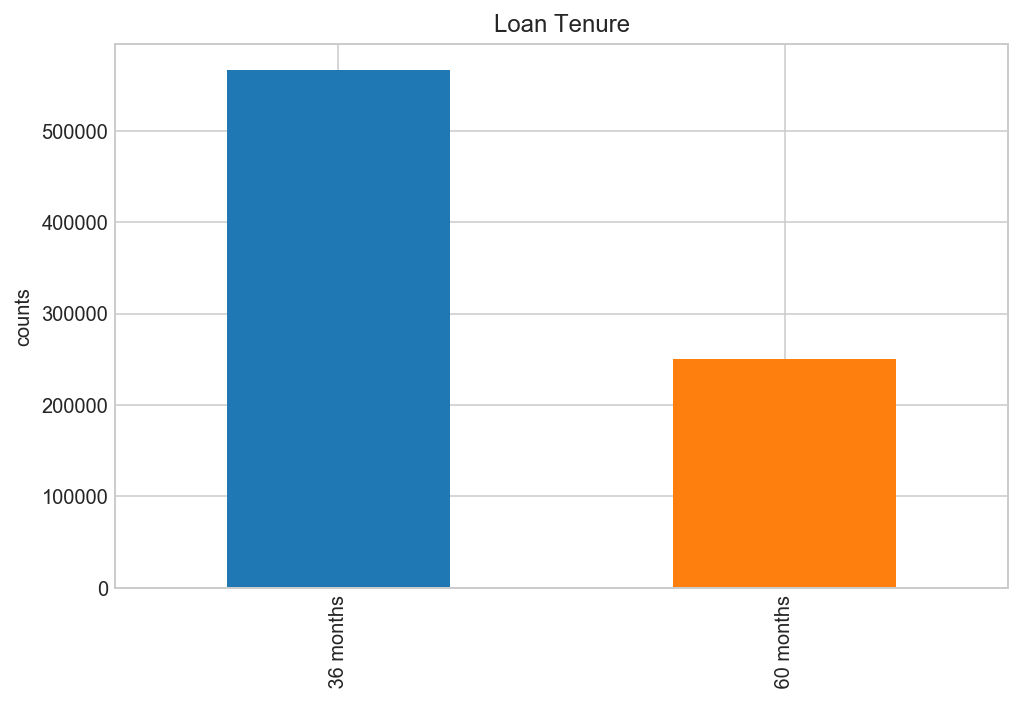

In [102]:
plt.figure(figsize=(8,5))
ax = data['term'].value_counts().plot(kind='bar',title='Loan Tenure')
#ax.set_xlabel("Good = 0 and Bad = 1")
ax.set_ylabel("counts")

# Processed Data

#### Final dataframe used for modelling is listed here, please see appendix notebook for details on cleaning and preparation of source data

In [11]:
data3.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,DEFAULT,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_n/a,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,issue_d_Apr-2014,issue_d_Apr-2015,issue_d_Aug-2012,issue_d_Aug-2013,issue_d_Aug-2014,issue_d_Aug-2015,issue_d_Dec-2012,issue_d_Dec-2013,issue_d_Dec-2014,issue_d_Dec-2015,...,earliest_cr_line_Sep-1959,earliest_cr_line_Sep-1960,earliest_cr_line_Sep-1961,earliest_cr_line_Sep-1962,earliest_cr_line_Sep-1963,earliest_cr_line_Sep-1964,earliest_cr_line_Sep-1965,earliest_cr_line_Sep-1966,earliest_cr_line_Sep-1967,earliest_cr_line_Sep-1968,earliest_cr_line_Sep-1969,earliest_cr_line_Sep-1970,earliest_cr_line_Sep-1971,earliest_cr_line_Sep-1972,earliest_cr_line_Sep-1973,earliest_cr_line_Sep-1974,earliest_cr_line_Sep-1975,earliest_cr_line_Sep-1976,earliest_cr_line_Sep-1977,earliest_cr_line_Sep-1978,earliest_cr_line_Sep-1979,earliest_cr_line_Sep-1980,earliest_cr_line_Sep-1981,earliest_cr_line_Sep-1982,earliest_cr_line_Sep-1983,earliest_cr_line_Sep-1984,earliest_cr_line_Sep-1985,earliest_cr_line_Sep-1986,earliest_cr_line_Sep-1987,earliest_cr_line_Sep-1988,earliest_cr_line_Sep-1989,earliest_cr_line_Sep-1990,earliest_cr_line_Sep-1991,earliest_cr_line_Sep-1992,earliest_cr_line_Sep-1993,earliest_cr_line_Sep-1994,earliest_cr_line_Sep-1995,earliest_cr_line_Sep-1996,earliest_cr_line_Sep-1997,earliest_cr_line_Sep-1998,earliest_cr_line_Sep-1999,earliest_cr_line_Sep-2000,earliest_cr_line_Sep-2001,earliest_cr_line_Sep-2002,earliest_cr_line_Sep-2003,earliest_cr_line_Sep-2004,earliest_cr_line_Sep-2005,earliest_cr_line_Sep-2006,earliest_cr_line_Sep-2007,earliest_cr_line_Sep-2008,earliest_cr_line_Sep-2009,earliest_cr_line_Sep-2010,earliest_cr_line_Sep-2011,earliest_cr_line_Sep-2012,initial_list_status_w,next_pymnt_d_Jan-2016,next_pymnt_d_Mar-2016,next_pymnt_d_isthisrelevant?,last_credit_pull_d_Apr-2014,last_credit_pull_d_Apr-2015,last_credit_pull_d_Aug-2012,last_credit_pull_d_Aug-2013,last_credit_pull_d_Aug-2014,last_credit_pull_d_Aug-2015,last_credit_pull_d_Dec-2012,last_credit_pull_d_Dec-2013,last_credit_pull_d_Dec-2014,last_credit_pull_d_Dec-2015,last_credit_pull_d_Feb-2013,last_credit_pull_d_Feb-2014,last_credit_pull_d_Feb-2015,last_credit_pull_d_Jan-2013,last_credit_pull_d_Jan-2014,last_credit_pull_d_Jan-2015,last_credit_pull_d_Jan-2016,last_credit_pull_d_Jul-2013,last_credit_pull_d_Jul-2014,last_credit_pull_d_Jul-2015,last_credit_pull_d_Jun-2013,last_credit_pull_d_Jun-2014,last_credit_pull_d_Jun-2015,last_credit_pull_d_Mar-2013,last_credit_pull_d_Mar-2014,last_credit_pull_d_Mar-2015,last_credit_pull_d_May-2013,last_credit_pull_d_May-2014,last_credit_pull_d_May-2015,last_credit_pull_d_Nov-2012,last_credit_pull_d_Nov-2013,last_credit_pull_d_Nov-2014,last_credit_pull_d_Nov-2015,last_credit_pull_d_Oct-2012,last_credit_pull_d_Oct-2013,last_credit_pull_d_Oct-2014,last_credit_pull_d_

# Statistical Analysis & Modelling

### Preliminaries and Preparation of Data

In [2]:
# Preparation of data for modelling
data3 = pd.read_pickle('dataupdate02052018 - 1percent.pkl')

df_train, df_test = train_test_split(data3, test_size=0.2, stratify=data3['DEFAULT'])

X = df_train.loc[:, df_train.columns != 'DEFAULT']
y = df_train['DEFAULT']

rs = RobustScaler()
X = rs.fit_transform(X)

In [9]:
#data4 = data3.drop(['DEFAULT'],axis=1)
#data4.shape

In [3]:
df_test.shape

(1634, 932)

In [4]:
df_train['DEFAULT'].value_counts()

0    6149
1     384
Name: DEFAULT, dtype: int64

In [5]:
df_train.shape

(6533, 932)

### Rebalancing of classes

#### Imbalanced data

In [22]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y,test_size=0.20,stratify=y)

#### Rebalancing using SMOTETomek (for other methods attempted but not considered please see appendix)

In [6]:
print('Original dataset shape {}'.format(Counter(y)))

# Class to perform over-sampling using SMOTE and cleaning using 'Tomek links'
smt = SMOTETomek(random_state=42,n_jobs=-1)
X_res, y_res = smt.fit_sample(X, y)

print('Resampled dataset shape {}'.format(Counter(y_res)))

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,test_size=0.20,stratify=y_res)

Original dataset shape Counter({0L: 6149, 1L: 384})


C:\Users\arb_b\Anaconda2\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
C:\Users\arb_b\Anaconda2\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


Resampled dataset shape Counter({0: 6096, 1: 6096})


#### Rebalancing using SMOTEENN

In [17]:
print('Original dataset shape {}'.format(Counter(y)))

# Class to perform over-sampling using SMOTE and cleaning using 'ENN'
smn = SMOTEENN(random_state=42,n_jobs=-1)
X_res2, y_res2 = smn.fit_sample(X, y)

print('Resampled dataset shape {}'.format(Counter(y_res2)))

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_res2, y_res2,test_size=0.20,stratify=y_res2)

Original dataset shape Counter({0L: 6149, 1L: 384})


C:\Users\arb_b\Anaconda2\lib\site-packages\imblearn\combine\smote_enn.py:224: DeprecationWarning: Parameters initialization will be replaced in version 0.4. Use a SMOTE object instead.
  DeprecationWarning)
C:\Users\arb_b\Anaconda2\lib\site-packages\imblearn\combine\smote_enn.py:251: DeprecationWarning: Parameters initialization will be replaced in version 0.4. Use a ENN object instead.
  DeprecationWarning)
C:\Users\arb_b\Anaconda2\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
C:\Users\arb_b\Anaconda2\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


Resampled dataset shape Counter({1: 5977, 0: 3867})


### Model Selection

#### Running a preliminary screening of different algorithms to select best performing ones (based on AUC-ROC scoring) for further analysis and use.

In [19]:
models = [LogisticRegression(),AdaBoostClassifier(n_estimators=100),DecisionTreeClassifier(),\
          GradientBoostingClassifier(),RandomForestClassifier(n_estimators=100),\
          GaussianNB(),IsolationForest(),XGBClassifier()]
list1 = []
for model in models:
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_test, y_test, cv=10,\
                                                     n_jobs=-1,scoring='roc_auc').mean()
    print model, '\n ROC-AUC Score is', score
    list1.append(score)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 ROC-AUC Score is 0.9831376716717463
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None) 
 ROC-AUC Score is 0.9885773226361861
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 
 ROC-AUC Score is 0.9321538051446089
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max

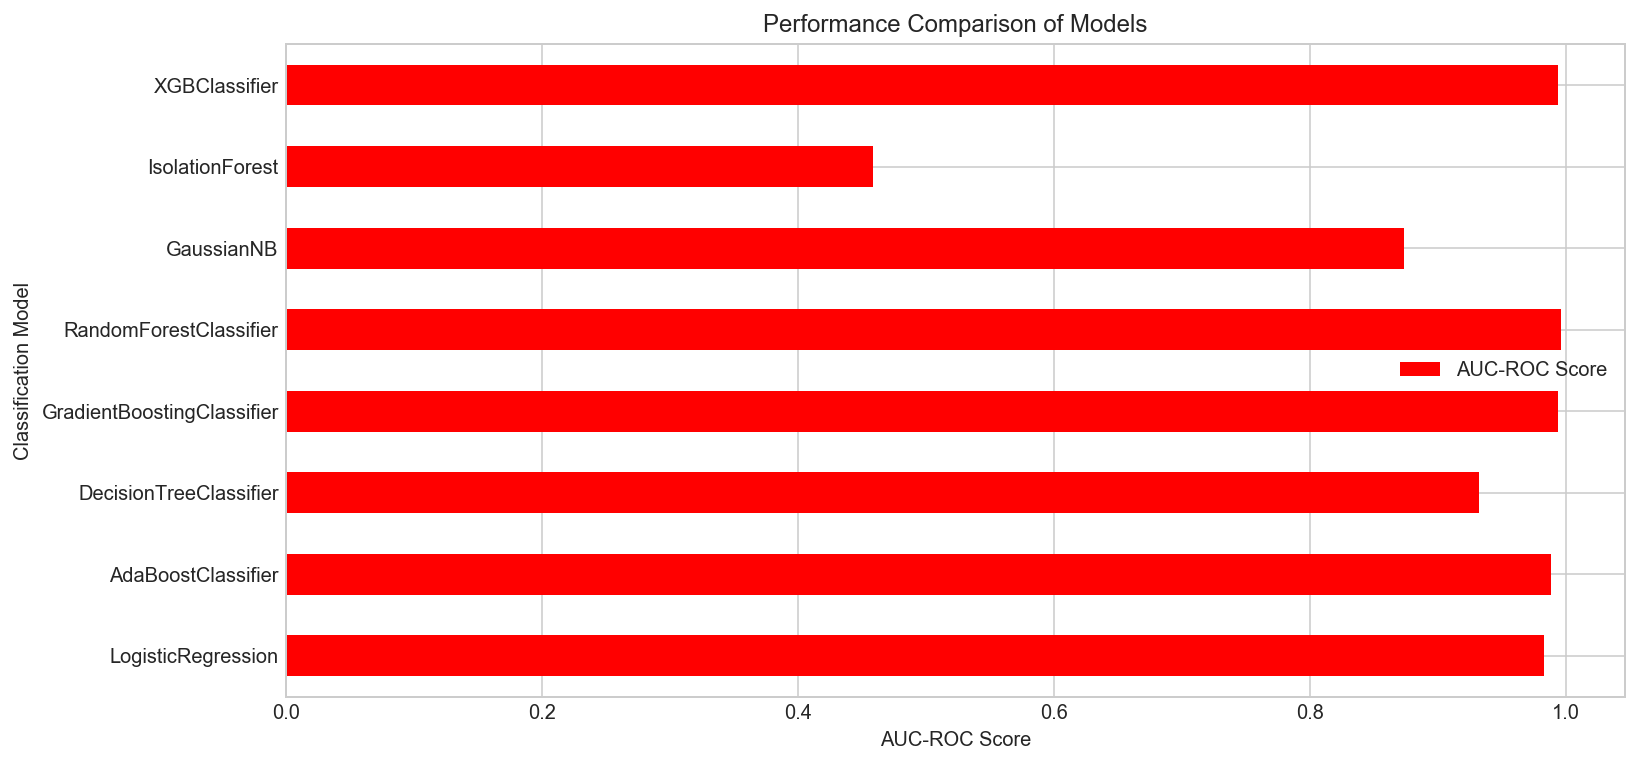

In [76]:
x = ['LogisticRegression','AdaBoostClassifier','DecisionTreeClassifier',\
          'GradientBoostingClassifier','RandomForestClassifier',\
          'GaussianNB','IsolationForest','XGBClassifier']
modeldf = pd.DataFrame(
    {'Model': x,
     'AUC-ROC Score': list1})

#colors = ['blue', 'blue', 'blue', 'black', 'red', 'blue', 'blue', 'red']
#plt.barh(x, list1, color=(0.2, 0.2, 0.2, 0.4, 0.4, 0.2, 0.2, 0.4))
ax = modeldf.plot(kind='barh', title='Performance Comparison of Models',figsize=(12,6),legend=False,color='r')
ax.set_yticklabels(modeldf.Model)
ax.set_xlabel("AUC-ROC Score")
ax.set_ylabel("Classification Model")
plt.legend(loc='center right')
plt.show()

#### The following 3 models are selected for further analysis: Logistic Regression (for ease of use and interpretability) is taken as the base model. Random Forest and Gradient Boost are the alternative models selected (for higher precision/recall). Gradient Boost was favoured over XGBoost given its marginally quicker computation.

### Feature Selection

#### Understanding important features for Gradient Boost model

In [7]:
gdb = GradientBoostingClassifier()
gdb.fit(X_train, y_train)
# feature_importances = pd.DataFrame(gdb.feature_importances_,
                                   #index = X_train.columns,
                                    #columns=['importance']).sort_values('importance', ascending=False)
for feature in zip(data3.columns, gdb.feature_importances_):
    print (feature)

('loan_amnt', 0.004994541384415405)
('funded_amnt', 0.0001213621291697349)
('funded_amnt_inv', 0.01134595371635594)
('int_rate', 0.031549442537637626)
('installment', 0.005777418187586477)
('annual_inc', 0.0013492724868566653)
('dti', 0.0011443421292430804)
('delinq_2yrs', 0.002251825244563338)
('inq_last_6mths', 0.009271710720153587)
('mths_since_last_delinq', 0.009350439502052789)
('open_acc', 0.0010049547218070394)
('pub_rec', 0.011869965920051432)
('revol_bal', 0.001318043932648088)
('revol_util', 0.00792036949057159)
('total_acc', 0.004914733950489263)
('out_prncp', 0.00323774922737725)
('out_prncp_inv', 0.0)
('total_pymnt', 0.0023366325099727016)
('total_pymnt_inv', 8.011771270839883e-05)
('total_rec_prncp', 0.05015365840745524)
('total_rec_int', 0.015331953279026112)
('total_rec_late_fee', 0.018735651933874296)
('recoveries', 0.024116918893708306)
('collection_recovery_fee', 0.0017759833862759217)
('last_pymnt_amnt', 0.05839659495253713)
('collections_12_mths_ex_med', 0.0)
('acc

#### We will select the features above a certain threshold, to be investigated later.

#### Understanding important features for Random Forest model

In [29]:
rdf = RandomForestClassifier(n_estimators=100)
rdf.fit(X_train, y_train)
# feature_importances = pd.DataFrame(rdf.feature_importances_,
                                   #index = X_train.columns,
                                    #columns=['importance']).sort_values('importance', ascending=False)
templist2 = zip(data3.columns, rdf.feature_importances_)
for feature in templist2:
    print (feature)

('loan_amnt', 0.009365758405088716)
('funded_amnt', 0.00897838773620985)
('funded_amnt_inv', 0.008342300596407858)
('int_rate', 0.030176190697523645)
('installment', 0.009439371209526386)
('annual_inc', 0.008927488871695637)
('dti', 0.00788877306046562)
('delinq_2yrs', 0.007641025021782717)
('inq_last_6mths', 0.01918964489301886)
('mths_since_last_delinq', 0.008756978330640037)
('open_acc', 0.007693935212936601)
('pub_rec', 0.005801896218148279)
('revol_bal', 0.007278739815381335)
('revol_util', 0.008443654855259169)
('total_acc', 0.007562290237093344)
('out_prncp', 0.03593210053872382)
('out_prncp_inv', 0.0328956434262875)
('total_pymnt', 0.019003855221889986)
('total_pymnt_inv', 0.02077052345711175)
('total_rec_prncp', 0.027842865490939818)
('total_rec_int', 0.017334890172966688)
('total_rec_late_fee', 0.011620648151394065)
('recoveries', 0.03033724016619688)
('collection_recovery_fee', 0.033037186095665694)
('last_pymnt_amnt', 0.0449622763030309)
('collections_12_mths_ex_med', 0.000

#### We will select the features that that have an importance of more than 0.02. This is rather arbitrary, but the idea is to reduce the number of features to reduce complexity.

In [25]:
sfm = SelectFromModel(rdf, threshold=0.02)
sfm.fit(X_train, y_train)
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
clf_important.fit(X_important_train, y_train)
# y_pred = clf_important.predict(X_important_test)
print "Feat Selected Random Forest Recall Score:\t", cross_val_score(clf_important, X_important_test, y_test, cv=10, n_jobs=-1,verbose=1,\
                                                             scoring='roc_auc').mean()

Feat Selected Random Forest Recall Score:	0.9807452009035161


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


#### ROC-AUC drops to 0.981 from 0.996 with reduced features, but this seems acceptable as features are now no longer in the hundreds.

#### Understanding features to use for logistic regression model

In [8]:
# this takes forever to run, do not touch the results here
lrcv = LogisticRegressionCV(penalty='l1', Cs=100, cv=10, solver='liblinear',n_jobs=-1)
lrcv.fit(X_train, y_train)
lrcv.C_

array([8.49753436])

In [10]:
# this takes forever to run, do not touch the results here
coeffs = pd.DataFrame(lrcv.coef_, columns=data4.columns)
coeffs_t = coeffs.transpose()
coeffs_t.columns = ['lasso_coefs']
coeffs_abs = coeffs_t.abs().sort_values('lasso_coefs', ascending=False)
coeffs_abs

,lasso_coefs
earliest_cr_line_Aug-1991,31.414871
earliest_cr_line_Aug-1999,25.919929
earliest_cr_line_Dec-1993,15.739882
issue_d_Sep-2015,14.484703
issue_d_Dec-2015,13.199642
earliest_cr_line_Mar-1992,11.963132
issue_d_Oct-2015,10.677623
earliest_cr_line_Nov-1989,10.609718
addr_state_OR,10.386113
earliest_cr_line_Sep-2003,10.359198


#### The lasso regularization has eliminated a number of features.

### Parameter Tuning

#### Using logistic regression model as baseline and reviewing results

In [43]:
# last run on 1% data
log2 = LogisticRegression(penalty='l2',C=0.1,class_weight='balanced')
log2.fit(X_train, y_train)
y_pred_class = log2.predict(X_test)

print "Logistic Regression AUC-ROC Score:\t", cross_val_score(log2, X_test, y_test, cv=10, n_jobs=-1,verbose=1,\
                                                             scoring='roc_auc').mean()

print(classification_report(y_test, y_pred_class,target_names=['No Default','Default']))

Logistic Regression AUC-ROC Score:	

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.1s finished


0.9708626896213837
             precision    recall  f1-score   support

 No Default       0.91      0.96      0.93      1222
    Default       0.96      0.90      0.93      1221

avg / total       0.93      0.93      0.93      2443



In [44]:
# last run on 1% data
conmat = confusion_matrix(y_test, y_pred_class)
confusion = pd.DataFrame(conmat, index=['is_No Default', 'is_Default',],columns=['predicted_No Default','predicted_Default'])
confusion

,predicted_No Default,predicted_Default
is_No Default,1177,45
is_Default,123,1098


#### Results seem ok, but we should strive to reduce the false positives and false negatives further

#### Doing some hyperparameter runing for Logistic Regression Model

In [47]:
# this was done over a few iterations, final iteration is indicated here
param_grid2 = [
  {'C': [90, 100, 110],'class_weight':['balanced'],'penalty':['l2']}]
gs = GridSearchCV(LogisticRegression(),
                  param_grid=param_grid2,cv=10,verbose=1,n_jobs=-1,scoring='recall')

gs.fit(X_train, y_train)
y_pred_class = gs.predict(X_test)
print gs.best_params_
print gs.best_score_

# {'penalty': 'l2', 'C': 100, 'class_weight': 'balanced'}
# 0.9850222935346228

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished


{'penalty': 'l2', 'C': 100, 'class_weight': 'balanced'}
0.9699089875929473


#### Let's get the base results for the Gradient Boost model first

In [41]:
# last run on 1% data
gdb = GradientBoostingClassifier()
gdb.fit(X_train, y_train)
y_pred_class = gdb.predict(X_test)

print "Gradient Boost AUC-ROC Score:\t", cross_val_score(gdb, X_test, y_test, cv=10, n_jobs=-1,verbose=1,\
                                                             scoring='roc_auc').mean()

print(classification_report(y_test, y_pred_class,target_names=['No Default','Default']))

Gradient Boost AUC-ROC Score:	

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.6min finished


0.9961771917471406
             precision    recall  f1-score   support

 No Default       0.97      1.00      0.98      1222
    Default       1.00      0.97      0.98      1221

avg / total       0.98      0.98      0.98      2443



In [42]:
# last run on 1% data
conmat = confusion_matrix(y_test, y_pred_class)
confusion = pd.DataFrame(conmat, index=['is_No Default', 'is_Default',],columns=['predicted_No Default','predicted_Default'])
confusion
# precision is high but recall could be higher

,predicted_No Default,predicted_Default
is_No Default,1217,5
is_Default,33,1188


#### Base results for Gradient Boost are better than that of corresponding Logistic Regression

#### Doing some hyperparameter tuning for the Gradient Boost model with emphasis on tuning 'recall' so that fewer bad loans are given out

In [7]:
# this was done over a few iterations, final iteration is indicated here
param_grid1 = [
  {'learning_rate': [0.17],'max_depth': [11,12,13,14]}]
gs = GridSearchCV(GradientBoostingClassifier(),
                  param_grid=param_grid1,cv=10,verbose=1,n_jobs=-1,scoring='recall')

gs.fit(X_train, y_train)
y_pred_class = gs.predict(X_test)
print gs.best_params_
print gs.best_score_

# {'learning_rate': 0.17, 'max_depth': 14}
# 0.9856879983643426

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 252.8min finished


{'learning_rate': 0.17, 'max_depth': 14}
0.9856879983643426


#### Let's get the base results for the RandomForest model first

In [39]:
rdf = RandomForestClassifier(n_estimators=100)
rdf.fit(X_train, y_train)
y_pred_class = rdf.predict(X_test)

print "Random Forest AUC-ROC Score:\t", cross_val_score(rdf, X_test, y_test, cv=10, n_jobs=-1,verbose=1,\
                                                             scoring='roc_auc').mean()

print(classification_report(y_test, y_pred_class,target_names=['No Default','Default']))

Random Forest AUC-ROC Score:	

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   56.6s finished


0.9989723769295427
             precision    recall  f1-score   support

 No Default       0.98      1.00      0.99      1222
    Default       1.00      0.98      0.99      1221

avg / total       0.99      0.99      0.99      2443



In [40]:
# last run on 1% data
conmat = confusion_matrix(y_test, y_pred_class)
confusion = pd.DataFrame(conmat, index=['is_No Default', 'is_Default',],columns=['predicted_No Default','predicted_Default'])
confusion

,predicted_No Default,predicted_Default
is_No Default,1222,0
is_Default,23,1198


#### Random Forest appears to perform the best straight out of the box compared to the other two.

#### Doing some hyperparameter tuning for the Random Forest model with emphasis on tuning 'recall' so that fewer bad loans are given out

In [18]:
# this was done over a few iterations, latest results are listed here
param_grid1 = [
  {'n_estimators': [120,125,130],'max_depth': [22,23],'min_samples_split': [2],'max_features': [25,26]}]
gs = GridSearchCV(RandomForestClassifier(),
                  param_grid=param_grid1,cv=10,verbose=1,n_jobs=-1,scoring='recall')

gs.fit(X_train, y_train)
y_pred_class = gs.predict(X_test)
print gs.best_params_
print gs.best_score_

# best - {'max_features': 26, 'min_samples_split': 2, 'n_estimators': 115, 'max_depth': 23}
# 0.9846710395962167

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.9min finished


{'max_features': 25, 'min_samples_split': 2, 'n_estimators': 120, 'max_depth': 23}
0.9842622506335187


### Validation on Test Data

In [58]:
Xt = df_test.loc[:, df_test.columns != 'DEFAULT']
yt = df_test['DEFAULT']

rs = RobustScaler()
Xt = rs.fit_transform(Xt)

In [50]:
# using resampling data
gdb = GradientBoostingClassifier(learning_rate = 0.17, max_depth=14)
gdb.fit(X_train, y_train)

y_pred_class = gdb.predict(Xt)

# print "Random Forest AUC-ROC Score:\t", cross_val_score(rdf, Xt, yt, cv=10, n_jobs=-1,verbose=1,\
#                                                              scoring='roc_auc').mean()

print(classification_report(yt, y_pred_class,target_names=['No Default','Default']))

             precision    recall  f1-score   support

 No Default       0.98      0.99      0.99      1538
    Default       0.86      0.69      0.76        96

avg / total       0.97      0.97      0.97      1634



In [51]:
conmat = confusion_matrix(yt, y_pred_class)
confusion = pd.DataFrame(conmat, index=['is_No Default', 'is_Default',],columns=['predicted_No Default','predicted_Default'])
confusion
# results for false positives was higher using max depth 12

,predicted_No Default,predicted_Default
is_No Default,1527,11
is_Default,30,66


In [27]:
gdbsaved = pickle.dumps(gdb)
# clf2 = pickle.loads(gdbsaved)

#### Precision is fairly high using Gradient Boost, but Recall is not necessarily high enough since we want to avoid giving out bad loans

#### Trying the Random Forest Model

In [48]:
# using resampling data
rdf = RandomForestClassifier(max_features=25, min_samples_split=2, n_estimators= 120, max_depth=23)
rdf.fit(X_train, y_train)

y_pred_class2 = rdf.predict(Xt)

# print "Random Forest AUC-ROC Score:\t", cross_val_score(rdf, Xt, yt, cv=10, n_jobs=-1,verbose=1,\
#                                                              scoring='roc_auc').mean()

print(classification_report(yt, y_pred_class2,target_names=['No Default','Default']))

             precision    recall  f1-score   support

 No Default       0.97      1.00      0.99      1538
    Default       1.00      0.56      0.72        96

avg / total       0.97      0.97      0.97      1634



In [49]:
conmat = confusion_matrix(yt, y_pred_class2)
confusion = pd.DataFrame(conmat, index=['is_No Default', 'is_Default',],columns=['predicted_No Default','predicted_Default'])
confusion

,predicted_No Default,predicted_Default
is_No Default,1538,0
is_Default,42,54


In [52]:
rdfsaved = pickle.dumps(rdf)
# clf2 = pickle.loads(gdbsaved)

#### Random Forest results show very high precision, but recall doesnt fare as well as recall result using Gradient Boost 

#### Calculating results using Logistic Regression for comparison

In [12]:
# using resampling data and logistic regression
log1 = LogisticRegression(penalty='l2',C=0.1,class_weight='balanced')
log1.fit(X_train, y_train)

y_pred_class1 = log1.predict(Xt)

# print "Random Forest AUC-ROC Score:\t", cross_val_score(rdf, Xt, yt, cv=10, n_jobs=-1,verbose=1,\
#                                                              scoring='roc_auc').mean()

print(classification_report(yt, y_pred_class1,target_names=['No Default','Default']))

             precision    recall  f1-score   support

 No Default       0.98      0.96      0.97      1538
    Default       0.55      0.71      0.62        96

avg / total       0.96      0.95      0.95      1634



In [13]:
conmat = confusion_matrix(yt, y_pred_class1)
confusion = pd.DataFrame(conmat, index=['is_No Default', 'is_Default',],columns=['predicted_No Default','predicted_Default'])
confusion

,predicted_No Default,predicted_Default
is_No Default,1483,55
is_Default,28,68


In [26]:
log1saved = pickle.dumps(log1)
# clf2 = pickle.loads(gdbsaved)

#### Logistic Regression has best recall, but much lower precision than Gradient Boost and Random Forest

#### There is clearly a tradeoff between the models in terms of higher sensitivity (Logistic Regression) and higher specificity (Gradient Boost), with Random Forest lying somewhere in the middle of the spectrum. We can manually adjust the threshold based on the relative cost assigned to the false positives and false negatives to tune our model further - this is to be elaborated on in the findings section.

#### BONUS 1: Checking results for Gradient Boost + SMOTEENN

In [18]:
rdf = RandomForestClassifier(max_features=26, min_samples_split=2, n_estimators= 115, max_depth=23)
rdf.fit(X_train2, y_train2)

y_pred_class = rdf.predict(Xt)

# print "Random Forest AUC-ROC Score:\t", cross_val_score(rdf, Xt, yt, cv=10, n_jobs=-1,verbose=1,\
#                                                              scoring='roc_auc').mean()

print(classification_report(yt, y_pred_class,target_names=['No Default','Default']))

             precision    recall  f1-score   support

 No Default       0.98      1.00      0.99      1538
    Default       0.93      0.65      0.76        96

avg / total       0.98      0.98      0.97      1634



In [19]:
conmat = confusion_matrix(yt, y_pred_class)
confusion = pd.DataFrame(conmat, index=['is_No Default', 'is_Default',],columns=['predicted_No Default','predicted_Default'])
confusion

,predicted_No Default,predicted_Default
is_No Default,1533,5
is_Default,34,62


#### Precision-Recall results are comparable to that rebalanced using SMOTETOMEK

#### BONUS 2: Testing the relative difference had we not done rebalancing of classes at the start

In [23]:
rdf = RandomForestClassifier(max_features=26, min_samples_split=2, n_estimators= 115, max_depth=23)
rdf.fit(X_train1, y_train1)

y_pred_class = rdf.predict(Xt)

# print "Random Forest AUC-ROC Score:\t", cross_val_score(rdf, Xt, yt, cv=10, n_jobs=-1,verbose=1,\
#                                                              scoring='roc_auc').mean()

print(classification_report(yt, y_pred_class,target_names=['No Default','Default']))

             precision    recall  f1-score   support

 No Default       0.96      1.00      0.98      1538
    Default       1.00      0.38      0.55        96

avg / total       0.96      0.96      0.96      1634



In [24]:
conmat = confusion_matrix(yt, y_pred_class)
confusion = pd.DataFrame(conmat, index=['is_No Default', 'is_Default',],columns=['predicted_No Default','predicted_Default'])
confusion

,predicted_No Default,predicted_Default
is_No Default,1538,0
is_Default,60,36


In [25]:
# conf_mat = confusion_matrix(yt, y_pred_class)
# fig, ax = plt.subplots(figsize=(5,5))
# sns.heatmap(conf_mat, annot=True,
#             yticklabels=['0', '1'], xticklabels=['0','1'],cmap="YlGnBu")
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()

#### Clearly the results are skewed towards the majority class had the test data not been rebalanced first

# Summary of Findings & Results

### Model Performance

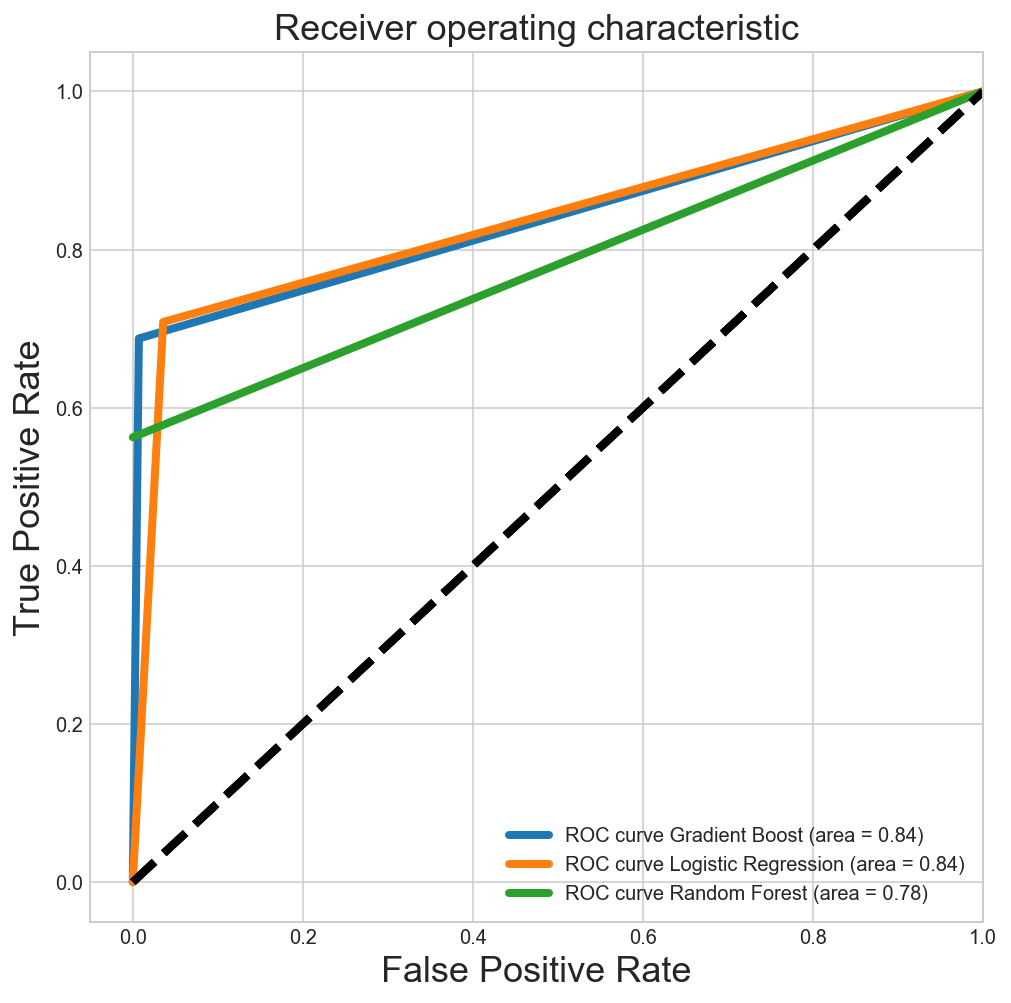

In [53]:
fpr, tpr, _ = roc_curve(yt, y_pred_class)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve Gradient Boost (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
# plt.show()

fprlog, tprlog, _ = roc_curve(yt, y_pred_class1)
roc_auc1 = auc(fprlog, tprlog)

plt.plot(fprlog, tprlog, label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc1, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.legend(loc="lower right")

fprrdf, tprrdf, _ = roc_curve(yt, y_pred_class2)
roc_auc2 = auc(fprrdf, tprrdf)

plt.plot(fprrdf, tprrdf, label='ROC curve Random Forest (area = %0.2f)' % roc_auc2, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.legend(loc="lower right")

plt.show()

### Limitations

#### Precision-Recall for Logistic Regression and Tuning of Thresholds

In [13]:
# for logistic regression
y_score = log1.decision_function(Xt)
average_precision = average_precision_score(yt, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.85


Text(0.5,1,u'Precision-Recall curve for Logistic Regression: AP=0.85')

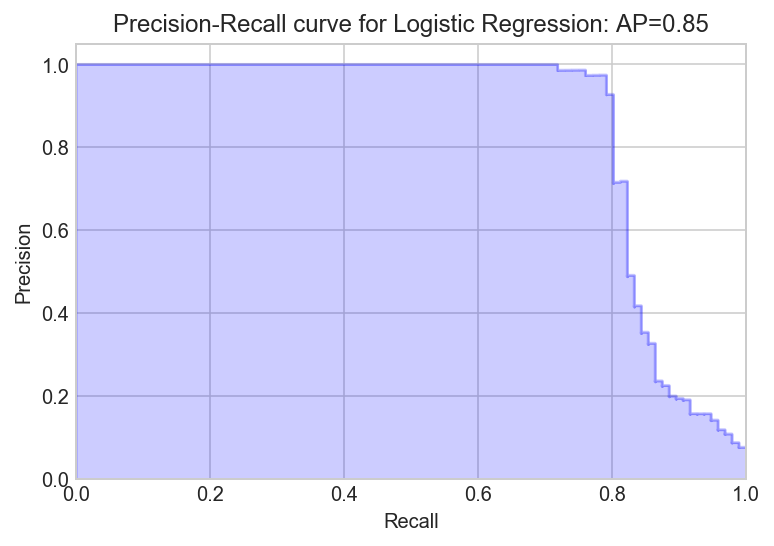

In [14]:
precision, recall, _ = precision_recall_curve(yt, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Logistic Regression: AP={0:0.2f}'.format(
          average_precision))

#### Tuning of Logistic Regression Model by adjusting the thresholds

In [60]:
# default standard threshold of 0.5
log1 = LogisticRegression(penalty='l2',C=0.1,class_weight='balanced')
log1.fit(X_train, y_train)
y_pred_prob = log1.predict_proba(Xt)[:, 1]
y_pred_class3 = binarize(y_pred_prob.reshape(1, -1), 0.5)[0]
print(confusion_matrix(yt, y_pred_class3))

[[1458   80]
 [  18   78]]


In [64]:
# varying threshold to 0.7
y_pred_class4 = binarize(y_pred_prob.reshape(1, -1), 0.7)[0]
print(confusion_matrix(yt, y_pred_class4))

[[1517   21]
 [  23   73]]


In [65]:
# varying threshold to 0.3
y_pred_class5 = binarize(y_pred_prob.reshape(1, -1), 0.3)[0]
print(confusion_matrix(yt, y_pred_class5))

[[1292  246]
 [  12   84]]


#### Precision-Recall characteristic for Random Forest

In [68]:
# for random forest
rdf = RandomForestClassifier(max_features=25, min_samples_split=2, n_estimators= 120, max_depth=23)
rdf.fit(X_train, y_train)

y_score = rdf.decision_path(Xt)
average_precision = average_precision_score(yt, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

ValueError: Found input variables with inconsistent numbers of samples: [1634, 2]

In [ ]:
precision, recall, _ = precision_recall_curve(yt, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Gradient Boost: AP={0:0.2f}'.format(
          average_precision))

#### Precision-Recall characteristic for Gradient Boost

In [15]:
# for gradient boost
y_score = gdb.decision_function(Xt)
average_precision = average_precision_score(yt, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.81


Text(0.5,1,u'Precision-Recall curve for Gradient Boost: AP=0.81')

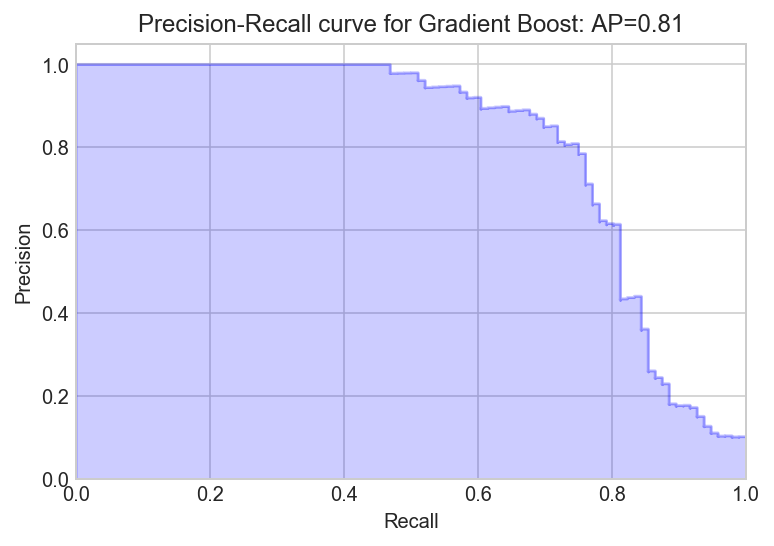

In [16]:
precision, recall, _ = precision_recall_curve(yt, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Gradient Boost: AP={0:0.2f}'.format(
          average_precision))

# Conclusion & Follow-Ups

### Conclusion
#### The _ models produce  


### Follow-Ups
#### The primary follow up would be to repeat this process and re-run the models on the entire population of data. Given the time taken (in particular for the hyper parameter tuning), cloud computing is likely to be required.
#### A secondary follow-up would be to simplify the models even further by reducing the number of features to include in the models. This would facilitate ease of implementation as fewer applicant details will need to be obtained in order to predict whether a loan should be approved, though this may come at the expense of lower overall precision and accuracy.